# cNMF in `cellarium-ml`

Stephen Fleming, Yang Xu

2025.07.31

The `cellarium-ml` project:

https://github.com/cellarium-ai/cellarium-ml

The specific implementation of cNMF we are actively working on:

https://github.com/cellarium-ai/cellarium-ml/pull/196

## Overview

`cellarium-ml` implements a variety of algorithms in a way that is scalable to hundreds of millions of cells and beyond.
This notebook provides a demo run of Cellarium's implementation of consensus NMF (cNMF).
The specific algorithm for NMF is based on "Online learning for matrix factorization and sparse coding" by Mairal, Bach, Ponce, and Sapiro (JMLR 2010).

## This notebook

This notebook shows an end-to-end cNMF run in `cellarium-ml`, starting with h5ad files and ending with results.
There are several steps involved.

## Description of analysis steps

1. Compute highly-variable genes.

2. Run cNMF on selected highly-variable genes.

3. Interactive plotting in this notebook to help determine optimal number of programs `k`, and a 
   `density_threshold` and `local_neighborhood_size` for the consensus step.

4. Computing consensus factors.

5. (Optional) Computing per-cell factor loadings.

6. (Optional) Re-computing the `k` factor definitions using all genes (not just highly-variable genes).

## Inputs

- a lits of filepaths to h5ad files: can be local or in a google bucket (or at some URL)
    - ideally the h5ad files would be from an extracted curriculum from `cellarium-nexus`, but these files can be any h5ad files
        - until [#324](https://github.com/cellarium-ai/cellarium-ml/issues/324) is resolved, the h5ad files
          should be limited in size to what can fit in memory

## Outputs

- stability plot to help choose the optimal consensus `k`
    - the example below would be for `k = 20`
- anndata object for all cells (with an empty count matrix) containing:
    - `adata.obsm["X_cnmf_k20"]`: (cell, k) matrix of per-cell factor loadings (for the `k = 20` decomposition)
    - `adata.obsp["cnmf_k20_factors_hvg"]`: (gene, k) matrix of definitions of each of the `k` consensus programs
        - from the initial cNMF fit: all non-highly-variable genes have weight zero
    - `adata.obsp["cnmf_k20_factors_hvg_tpm"]`: (gene, k) matrix of definitions of each of the `k` consensus programs
        - same as above but weights are recomputed to represent TPM values via a refitting step
    - `adata.obsp["cnmf_k20_factors"]`: (gene, k) matrix of definitions of each of the `k` consensus programs
        - computed by refitting cell loadings from `adata.obsp["cnmf_k20_factors_hvg"]` by refitting the dataset including all genes
    - `adata.obsp["cnmf_k20_factors_tpm"]`: (gene, k) matrix of definitions of each of the `k` consensus programs
        - same as above but weights are recomputed to represent TPM values via a refitting step
    - (optionally): all of the above for other choices of `k` as well

NOTE: You will need to use the `nmf` branch of `cellarium-ml` on github until PR #196 is merged.

In [1]:
import cellarium.ml.preprocessing
import cellarium.ml.data
import cellarium.ml.transforms
import cellarium.ml.api
import cellarium.ml.models

import lightning.pytorch as pl
import numpy as np

/Users/sfleming/miniconda3/envs/cellarium/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%load_ext autoreload
%autoreload 2

# Data

In [3]:
# the data

h5ad_paths = [
    # "https://datasets.cellxgene.cziscience.com/8674c375-ae3a-433c-97de-3c56cf8f7304.h5ad"
    "https://storage.googleapis.com/dsp-cellarium-cas-public/test-data/test_0.h5ad",
    "https://storage.googleapis.com/dsp-cellarium-cas-public/test-data/test_1.h5ad",
    "https://storage.googleapis.com/dsp-cellarium-cas-public/test-data/test_2.h5ad",
]

In [4]:
# for demonstration purposes: automatically grab h5ad file paths from a bucket prefix, like data from Nexus

try:
    example_cellarium_curriculum_h5ad_paths = cellarium.ml.api.h5ad_paths_from_google_bucket(
        "gs://cellarium-nexus-file-system-335649/pipeline/data-extracts/TEST2/extract_files"
    )
    print("Example of how to grab files from a Nexus curriculum bucket path:")
    print(f"[{example_cellarium_curriculum_h5ad_paths[0]}, ...]")
except:
    pass

Example of how to grab files from a Nexus curriculum bucket path:
[gs://cellarium-nexus-file-system-335649/pipeline/data-extracts/TEST2/extract_files/extract_0.h5ad, ...]


## Cellarium data setup

For this demo we are using the python API for cellarium.  It's also possible to use command line versions of these tools.

In [5]:
h5ad_paths

['https://storage.googleapis.com/dsp-cellarium-cas-public/test-data/test_0.h5ad',
 'https://storage.googleapis.com/dsp-cellarium-cas-public/test-data/test_1.h5ad',
 'https://storage.googleapis.com/dsp-cellarium-cas-public/test-data/test_2.h5ad']

In [6]:
datamodule = cellarium.ml.CellariumAnnDataDataModule(
    dadc=cellarium.ml.data.DistributedAnnDataCollection(
        filenames=h5ad_paths,
        limits=np.cumsum(cellarium.ml.api.get_h5ad_files_n_cells(h5ad_paths))
    ),
    batch_keys={
        "x_ng": cellarium.ml.utilities.data.AnnDataField(attr="X", convert_fn=cellarium.ml.utilities.data.densify),
        "var_names_g": cellarium.ml.utilities.data.AnnDataField(attr="var_names"),
        "obs_names_n": cellarium.ml.utilities.data.AnnDataField(attr="obs_names"),
    },
    batch_size=50,
    shuffle=True,
    train_size=1.0,
)

datamodule.setup(stage="fit")

# Highly variable genes

## Run onepass model

This computes mean and variance per gene.

In [7]:
# get gene names to use later (and assume all files have the same genes)

var_names_g = cellarium.ml.api.get_h5ad_file_var_names_g(h5ad_paths[0])
var_names_g[:3]

array(['ENSG00000187642', 'ENSG00000078808', 'ENSG00000272106'],
      dtype='<U15')

In [8]:
# set up the model that will be used to compute mean and var of each gene

onepass_module = cellarium.ml.CellariumModule(
    transforms=[
        cellarium.ml.transforms.NormalizeTotal(),
        cellarium.ml.transforms.Log1p(),
    ],
    model=cellarium.ml.models.OnePassMeanVarStd(
        var_names_g=cellarium.ml.api.get_h5ad_file_var_names_g(h5ad_paths[0]),
    )
)

In [9]:
trainer = pl.Trainer(
    accelerator="cpu",
    devices=1,
    max_epochs=1,
    default_root_dir="tmp/onepass",
)
trainer.fit(onepass_module, datamodule)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name     | Type              | Params | Mode 
-------------------------------------------------------
0 | pipeline | CellariumPipeline | 1      | train
-------------------------------------------------------
1         Trainable params
0         Non-trainable params
1         Total params
0.000     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 6/6 [00:02<00:00,  2.78it/s, v_num=12]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 6/6 [00:02<00:00,  2.77it/s, v_num=12]


In [10]:
# the onepass model computes a mean and variance per gene

mean_g = trainer.model.model.mean_g
var_g = trainer.model.model.var_g

## Compute hvgs

You can choose `n_top_genes` to suit your needs.

In [11]:
var = cellarium.ml.preprocessing.get_highly_variable_genes(
    gene_names=var_names_g,
    mean=mean_g,
    var=var_g,
    n_top_genes=2000,
)
var

,means,dispersions,mean_bin,dispersions_norm,highly_variable
ENSG00000187642,3.396082e-03,-0.496453,"(-0.00186, 0.0931]",-0.475822,False
ENSG00000078808,2.680669e-01,-0.107399,"(0.186, 0.279]",-0.490836,False
ENSG00000272106,3.876293e-02,0.039590,"(-0.00186, 0.0931]",0.473102,False
ENSG00000162585,2.412543e-01,-0.155123,"(0.186, 0.279]",-0.710901,False
ENSG00000272088,1.000000e-12,NaN,"(-0.00186, 0.0931]",NaN,False
...,...,...,...,...,...
ENSG00000224281,7.871761e-03,-0.734107,"(-0.00186, 0.0931]",-0.896527,False
ENSG00000122121,2.499048e-03,-0.290152,"(-0.00186, 0.0931]",-0.110621,False
ENSG00000228836,1.000000e-12,NaN,"(-0.00186, 0.0931]",NaN,False
ENSG00000231937,1.774878e-03,-0.632692,"(-0.00186, 0.0931]",-0.717000,False


In [12]:
var['highly_variable'].sum()

2000

In [13]:
# the highly variable genes

hvg_var_names_g = var.index[var['highly_variable']]
hvg_var_names_g

Index(['ENSG00000162490', 'ENSG00000142798', 'ENSG00000143001',
       'ENSG00000016490', 'ENSG00000163216', 'ENSG00000162849',
       'ENSG00000281195', 'ENSG00000143954', 'ENSG00000256671',
       'ENSG00000080293',
       ...
       'ENSG00000173786', 'ENSG00000267750', 'ENSG00000150656',
       'ENSG00000181781', 'ENSG00000180855', 'ENSG00000125879',
       'ENSG00000124116', 'ENSG00000160183', 'ENSG00000159307',
       'ENSG00000100427'],
      dtype='object', length=2000)

# cNMF

## Run NMF

Set things up to run cNMF in cellarium.

In [14]:
# user's choice for the number of components: must input a python list

k_values = [10, 20, 30]
# k_values = list(range(10, 30))

In [15]:
nmf_model = cellarium.ml.models.NonNegativeMatrixFactorization(
    full_g=len(var_names_g),
    var_names_hvg=hvg_var_names_g,
    k_values=k_values,
    r=50,
)

nmf_module = cellarium.ml.CellariumModule(
    cpu_transforms=[cellarium.ml.transforms.Filter(filter_list=hvg_var_names_g)],
    model=nmf_model,
)

datamodule.setup(stage="fit")

trainer_nmf = pl.Trainer(
    accelerator="cpu",
    devices=1,
    max_epochs=1,
    default_root_dir="tmp/nmf",
)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [16]:
trainer_nmf.fit(nmf_module, datamodule)


  | Name     | Type              | Params | Mode 
-------------------------------------------------------
0 | pipeline | CellariumPipeline | 1      | train
-------------------------------------------------------
1         Trainable params
0         Non-trainable params
1         Total params
0.000     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 6/6 [00:08<00:00,  0.73it/s, v_num=25]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 6/6 [00:08<00:00,  0.73it/s, v_num=25]


In [17]:
# see the shape of what has been inferred: [replicates, k, genes]

for k in nmf_model.k_values:
    print(getattr(nmf_model, f"D_{k}_rkg").shape)

torch.Size([50, 10, 2000])
torch.Size([50, 20, 2000])
torch.Size([50, 30, 2000])


## Set up to explore outputs

We have a helper class that facilitates downstream analysis steps. Here we instantiate it.

In [18]:
from cellarium.ml.models.nmf import NMFOutput

nmf_output = NMFOutput(
    nmf_module=nmf_module,
    datamodule=datamodule,
)

In [19]:
nmf_output

NMFOutput(
    nmf_module=CellariumModule(pipeline = CellariumPipeline(
          (0): Filter(filter_list=['ENSG00000162490' 'ENSG00000142798' 'ENSG00000143001' ...
           'ENSG00000160183' 'ENSG00000159307' 'ENSG00000100427'])
          (1): NonNegativeMatrixFactorization(
            (transform__filter_to_hvgs): Filter(filter_list=['ENSG00000162490' 'ENSG00000142798' 'ENSG00000143001' ...
             'ENSG00000160183' 'ENSG00000159307' 'ENSG00000100427'])
          )
        )),
    datamodule={Train dataloader: size=6}
        {Validation dataloader: size=0}
        {Test dataloader: None}
        {Predict dataloader: None}
)
with consensus=None

## Compute consensus factors

as well as "stability" scores, a.k.a. silhouette scores

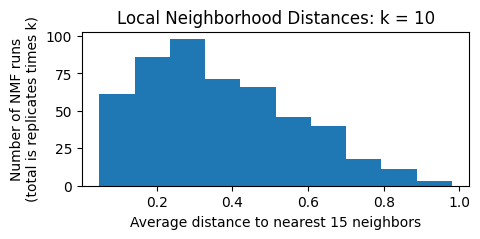

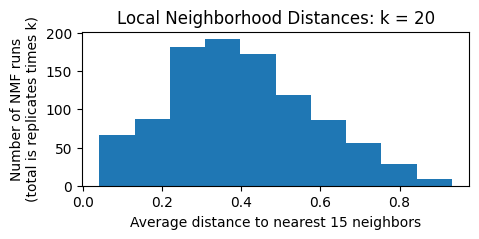

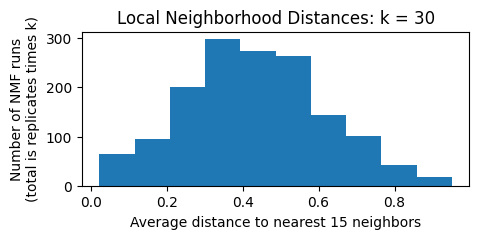

In [20]:
nmf_output.plot_density_histograms(local_neighborhood_size=0.3)

In [21]:
# for demonstration

try:
    nmf_output.consensus
except UserWarning as e:
    print("raises UserWarning: " + str(e))

raises UserWarning: Compute a consensus using compute_consensus_factors() -- entails hyperparameter choices


In [22]:
# calculate consensus D for all k-values

# change these thresholds if desired
density_threshold = 0.5
local_neighborhood_size = 0.3

nmf_output.compute_consensus_factors(
    density_threshold=density_threshold,
    local_neighborhood_size=local_neighborhood_size,
)

In [23]:
# one key for each k-value

nmf_output.consensus.keys()

dict_keys([10, 20, 30])

In [24]:
# each k-value has a few things computed

nmf_output.consensus[nmf_model.k_values[0]].keys()

dict_keys(['filtered_euclidean_distance_matrix', 'filtered_neighbor_distances', 'consensus_D_kg', 'stability'])

In [25]:
# the shape of the consensus matrix for a particular k

nmf_output.consensus[nmf_model.k_values[0]]['consensus_D_kg'].shape

torch.Size([10, 2000])

## Compute reconstruction error at each k

In [26]:
# we need to calculate the reconstruction error by going through the whole dataset: this can take time

nmf_output.calculate_reconstruction_error()

100%|██████████| 6/6 [00:02<00:00,  2.81it/s]


{10: 310329.3359375, 20: 277763.3515625, 30: 261311.33984375}

In [27]:
nmf_output.reconstruction_error

{10: 310329.3359375, 20: 277763.3515625, 30: 261311.33984375}

## Create the k-selection plot

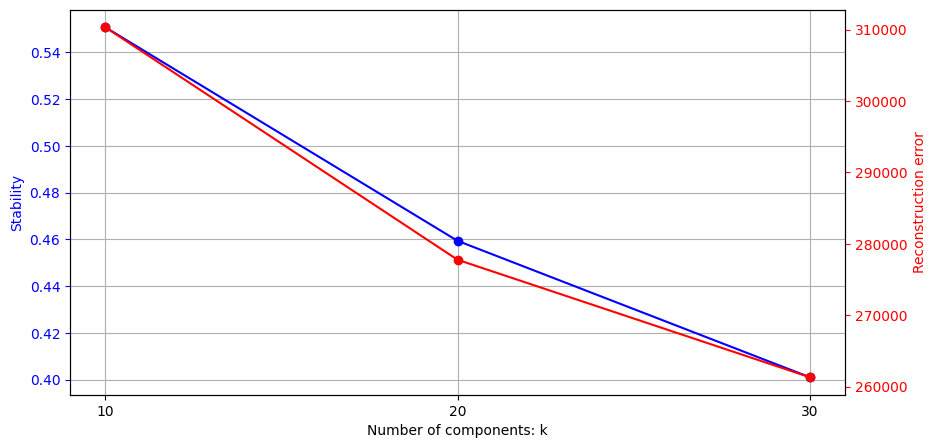

In [28]:
nmf_output.k_selection_plot()

## Create clustermap plots

In [29]:
# make a choice here
best_k = 20

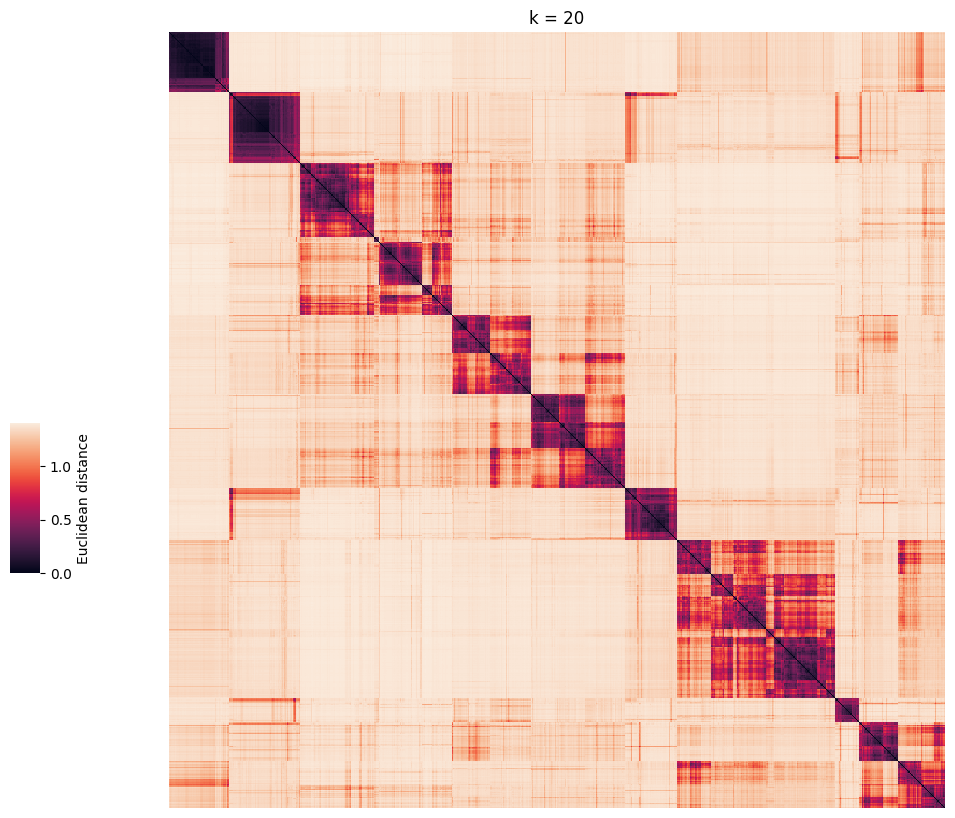

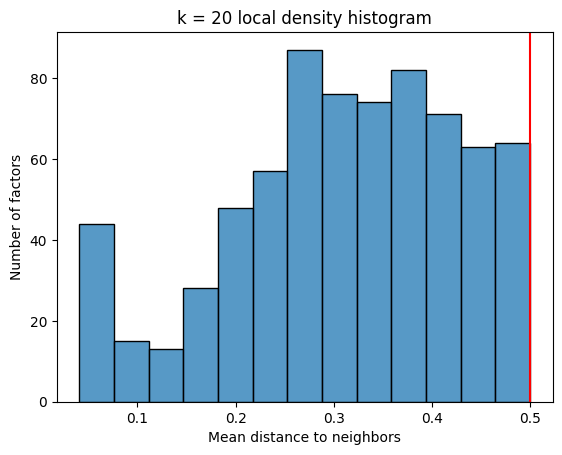

In [30]:
nmf_output.plot_clustermap(k=best_k)

## Compute per-cell loadings

The loadings of each factor, computed for each cell.

In [31]:
# get per-cell factor loadings using the best k: this takes time
# `normalize` controls whether the per-cell loadings sum to 1

df = nmf_output.compute_loadings(k=best_k, normalize=True)

100%|██████████| 6/6 [00:01<00:00,  4.06it/s]


In [32]:
df.shape

(300, 20)

In theory could add this information to the anndata object if you had a single object.
Here we will assume the dataset might be very large in total, so we will just try to open one h5ad file and add the annotations for those cells.

In [33]:
adata = cellarium.ml.data.read_h5ad_file(h5ad_paths[0])
adata

AnnData object with n_obs × n_vars = 100 × 36601
    obs: 'cell_type', 'cas_ingest_id', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'organism_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'tissue_ontology_term_id', 'assay', 'development_stage', 'disease', 'organism', 'self_reported_ethnicity', 'sex', 'tissue', 'total_mrna_umis', 'dataset_id', 'batch'
    layers: 'measured_genes_mask'

In [34]:
# add cNMF loadings to obsm

adata.obsm["X_nmf"] = df.loc[adata.obs_names].values
adata.obsm["X_nmf"].shape

(100, 20)

## Project factors back to all genes

Now refit for all genes, not just the highly variable genes. In cNMF this involves solving an auxiliary linear regression problem.

In [ ]:
full_D_kg = getattr(pipeline[-1], f"full_D_{best_k}_kg")
full_D_kg = full_D_kg.cpu().numpy()

full_D_kg = pd.DataFrame(full_D_kg)
full_D_kg.columns = adata.var.index
full_D_kg = full_D_kg.T

## Results as a summary anndata

The results can be packaged up into an anndata object if desired, and perhaps saved that way as an h5ad file.

Here we omit the actual count matrix, since in theory it is too big to fit in memory.